# Quantitative Trading Strategy
#### By: Ruby Han

## Abstract
Forecasting market movement is a long-time attractive topic. This project aims to evaluate different algorithmic strategies on Apple, Microsoft, ExxonMobil, Chevron, Tesla using S&P 500 index as the benchmark over a one-year period (2021). An agent framework was built to trigger buy or sell orders with an initial capital of $10,000 based on selected strategy. Return on investment (ROI) was used as the performance metric. Base model outperformed other strategies with ROI of 31.5\% but deep reinforcement learning model Evolution Strategy coming close in second place with ROI of 27.1\%. Success of each strategy varied wildly with each stock for the time period. Machine learning models fared better than technical indicator models.

## Problem Objective 
- Create a quantitative trading strategy for any stocks
- No restriction on number of times entering or exiting the market, or long/short for period of strategy
- Benchmark with S&P 500 index
- Elucidate results and conclusion
- Provide future work and considerations given more time and resources

## Models Built

**Base Model:**

- Buy and Hold: Invest initial capital on first day and hold until last trading day

**Technical Indicators:**

- Bollinger Bands: Momentum model using moving standard deviations as bands

- MACD: Moving average convergence divergence index

**Machine Learning Models**

- Evolution Strategy: Deep reinforcement learning model

- LSTM: Long short-term memory model


## Result Summary

**Performance Metrix:**

$$\text{Return on Investment (ROI)}=\frac{\text{Current Value of Investment}-\text{Investment Cost}}{\text{Investment Cost}}$$

![result_table](result_table.png)

## Navigation <a id = 0> </a>
- [Data Load](#1)
- [EDA](#2)
- [Feature Engineering](#3)
    - [MACD](#3.1)
    - [Bollinger](#3.2)
    - [RSI](#3.3)
    - [Normal Distribution](#3.4)
- [Model](#4)
    - [Base Model](#4.0)
    - [Bollinger Bands](#4.1)
    - [MACD](#4.2)
    - [LSTM](#4.3)
    - [Evolution Strategy](#4.4)
- [Result](#5)
- [Conclusion](#6)
- [Future Work](#7)
- [References](#8)

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from itertools import compress

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from IPython.display import Markdown as md

import yfinance as yf
import pandas_datareader as pdr

from feature_eng import MACD, bollinger_bands, RSI, momentum

import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, max_error

from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential

import backtrader as bt

pd.set_option("display.max_rows", None, # display all rows
              "display.max_columns", None, # display all columns
              "display.max_colwidth", None, # expand column width
              "display.html.use_mathjax", False) # disable Latex style mathjax rendering

## Data Load <a id = 1> </a> 
[Back to Top](#0)

- S&P 500 index data 

##### Terminology
- `Open` : Stock price at market open (USD)
- `High` : Highest price reached per day (USD)
- `Low` : Lowest price reached per day (USD)
- `Close` : Stock price at market close (USD)
- `Adj Close` : Adjusted stock price at market close (USD)
- `Volume` : Number of shares traded per day

In [2]:
# Obtain stock data from Yahoo Finance
start = '2021-01-04'
end = '2022-01-04'

tickers = [
    '^GSPC' # sp500 index
    ,'XOM' # exxon
    ,'CVX' # chevron
    ,'AAPL' # apple
    ,'TSLA' # tesla
    ,'MSFT' # microsoft
    ,'SPY' # sp500 ETF
          ]

for ticker in tickers:
    data = pdr.get_data_yahoo(ticker, '2000')
    data.to_csv(f'data/raw_stocks/{ticker}.csv')

# data = yf.download('AAPL', start=start, end=end)

## EDA <a id = 2> </a> 
[Back to Top](#0)

In [3]:
apple_raw_df = pd.read_csv('data/raw_stocks/AAPL.csv')
apple_raw_df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2000-01-03,1.004464,0.907924,0.936384,0.999442,535796800.0,0.855797
1,2000-01-04,0.987723,0.903460,0.966518,0.915179,512377600.0,0.783644
2,2000-01-05,0.987165,0.919643,0.926339,0.928571,778321600.0,0.795111
3,2000-01-06,0.955357,0.848214,0.947545,0.848214,767972800.0,0.726304
4,2000-01-07,0.901786,0.852679,0.861607,0.888393,460734400.0,0.760708


In [4]:
apple_raw_df.shape

(5576, 7)

In [5]:
apple_raw_df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,5576.000000,5576.000000,5576.000000,5576.000000,5.576000e+03,5576.000000
mean,25.597790,25.055282,25.326246,25.337188,4.267585e+08,24.230080
std,37.047319,36.222712,36.630190,36.653385,3.889380e+08,36.544004
min,0.235536,0.227143,0.231964,0.234286,3.934000e+07,0.200613
25%,1.576518,1.534911,1.560714,1.561786,1.556468e+08,1.337317
50%,11.966607,11.766428,11.865000,11.861250,3.107328e+08,10.156482
75%,30.956875,30.412499,30.660000,30.642500,5.666332e+08,28.196386
max,182.940002,179.119995,182.630005,182.009995,7.421641e+09,181.778397


In [6]:
apple_raw_df.dtypes

Date          object
High         float64
Low          float64
Open         float64
Close        float64
Volume       float64
Adj Close    float64
dtype: object

In [7]:
# Check for null values
# If exist, use last good value, mean, zero or drop observation
apple_raw_df.isna().sum()

Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

## Feature Engineering <a id = 3> </a> 
[Back to Top](#0)

- Indicators are tools that help traders/investors make buying/selling stocks decisions
- Technical indicators (features in our case):
    - Price
    - Volume
- The following features will be created:
    - Bollinger Bands
    - RSI
    - MACD
    - Moving Average
    - Momentum
    - Change
    - Volatility
    - Return
- Target variable: `Return`
- All other features will serve as predictors

In [8]:
!rm -rf data/raw_stocks/.ipynb_checkpoints
files = os.listdir('data/raw_stocks')
stocks = {}

for file in files:
    name = file.split('.')[0]
    stocks[name] = pd.read_csv(f'data/raw_stocks/{file}') 
    
    stocks[name]['Date'] = pd.to_datetime(stocks[name]['Date'])
    stocks[name].set_index('Date', inplace=True)
    
    # Bollinger Bands
    stocks[name]['upper_boll_band'], stocks[name]['lower_boll_band'] = bollinger_bands(stocks[name])
    
    # MACD
    stocks[name]['macd'], stocks[name]['signal'] = MACD(stocks[name])
    
    # RSI
    stocks[name]['rsi'] = RSI(stocks[name])
    
    # 7d MA
    stocks[name]['ma7'] = stocks[name].Close.rolling(window=7).mean()
    
    # 21d MA
    stocks[name]['ma21'] = stocks[name].Close.rolling(window=21).mean()
    
    # Momentum
    stocks[name]['momentum'] = momentum(stocks[name].Close, 3)
    
    # Difference between current and previous
    stocks[name]['change'] = (stocks[name].Close - stocks[name].Close.shift(1)).fillna(0)
    
    # Volatility
    stocks[name]['volatility'] = stocks[name].Close.ewm(21).std()
    
    # Return
    stocks[name]['return'] = round(stocks[name]['Close']/stocks[name]['Open'] - 1, 4)

    stocks[name].to_csv(f'data/stocks/{name}.csv')

In [9]:
files

['MSFT.csv',
 'XOM.csv',
 'CVX.csv',
 '^GSPC.csv',
 'TSLA.csv',
 'SPY.csv',
 'AAPL.csv']

In [10]:
apple_df = stocks['AAPL']

ticker_list = []

for i in files:
    ticker_name = i.split('.')[0]
    ticker_list.append(ticker_name)
ticker_list

['MSFT', 'XOM', 'CVX', '^GSPC', 'TSLA', 'SPY', 'AAPL']

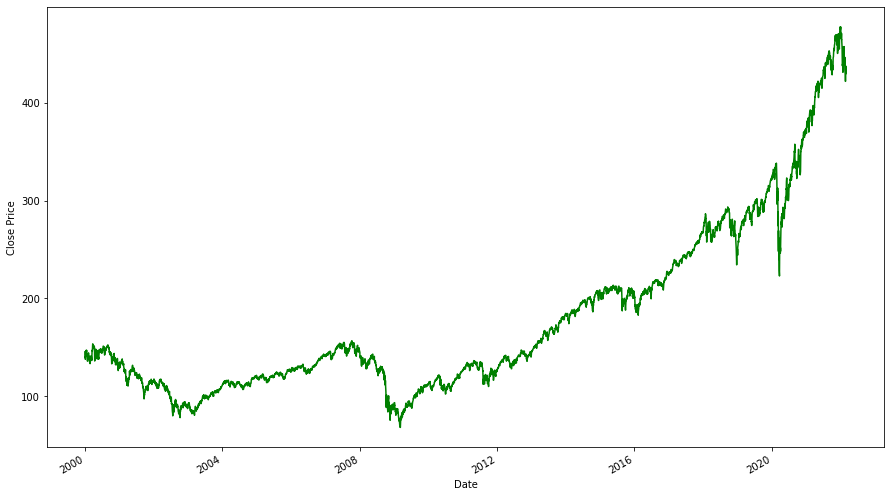

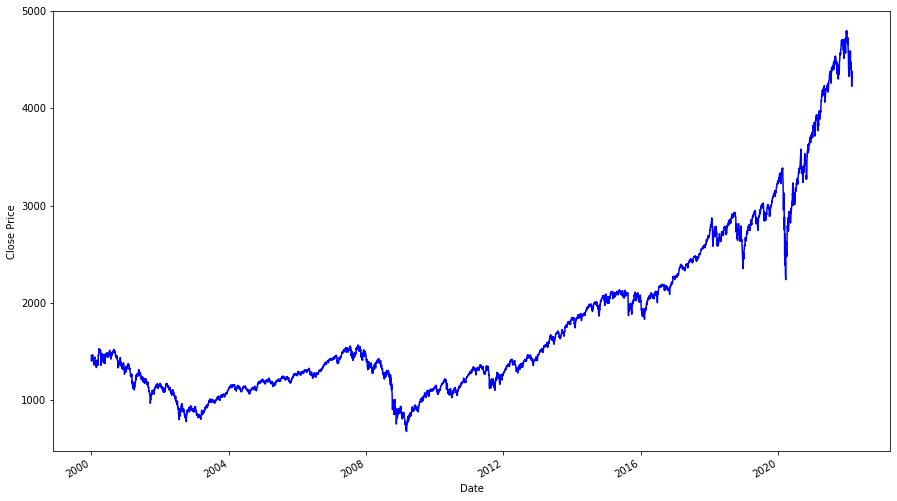

In [11]:
plt.figure(figsize = (15,9))
stocks['SPY'].Close.plot(c = 'g')
plt.ylabel('Close Price')
plt.show()

plt.figure(figsize = (15,9))
stocks['^GSPC'].Close.plot(c = 'b')
plt.ylabel('Close Price')
plt.show()

ticker_list.remove('^GSPC') # GSPC is an index and not tradeable

#### Correlation Plot
- `change` and `rsi` correlate with `return`

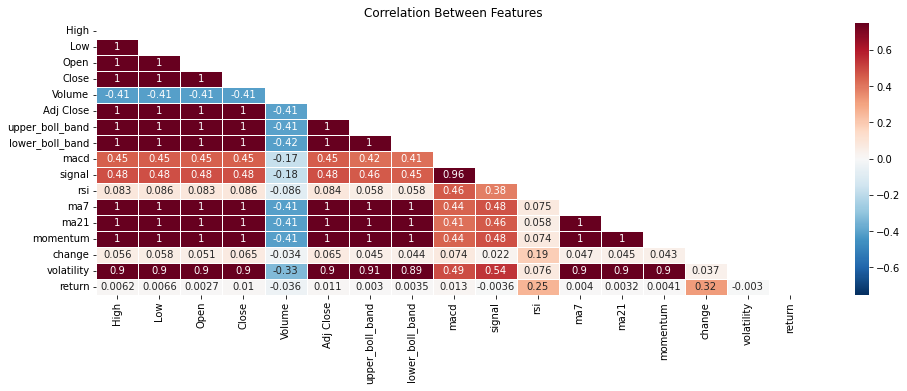

In [12]:
corr = apple_df.corr()

# Mask upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Plot correlation matrix
plt.figure(figsize=(16, 5))
heatmap = sns.heatmap(corr, mask=mask, annot=True, linewidths=0.5, 
                      vmin=-0.75, vmax=0.75, cmap="RdBu_r")
heatmap.set_title('Correlation Between Features');

In [13]:
corr[['return']].sort_values(by='return', ascending=False)

,return
return,1.000000
change,0.316699
rsi,0.253477
macd,0.013279
Adj Close,0.010615
Close,0.010190
Low,0.006577
High,0.006203
momentum,0.004107
ma7,0.004040


## $\underline{\text{Plots}}$

### MACD - Moving Average Convergence Divergence  <a id = 3.1> </a> 
[Back to Top](#0)
- Momentum indicator showing relationship between two moving averages
- Logic is that momentum has more impact on short moving average and we subtract short_ma from long_ma
- Difference is sometimes positive or negative, hence the name MACD (moving average converge/diverge oscillator)
    - Oscillator is the difference between the two MAs
    - When it is positive, we long and vice versa
- If short_ma > long_ma, then long and hold as stock is on the rise and will keep going up for some time
- If short_ma < long_ma, then clear positions

In [14]:
def macd(stock):
    plt.figure(figsize=(16,5))
    plt.plot(stock.macd, label='short_ma', color = '#b278ff')
    plt.plot(stock.signal, label='long_ma', color='#ffa74a')
    plt.axhline(0, color='#557692')
    plt.legend(frameon=True, loc=0, ncol=1, fontsize=10, borderpad=.6)
    plt.title('MACD', fontsize=15)
    plt.ylabel('Strength', fontsize=12)
    plt.show()
    
    plt.figure(figsize=(16,5))
    (stock.macd - stock.signal).plot(kind='bar',color='r')
    plt.grid(True)
    plt.xticks([])
    plt.xlabel('')
    plt.title('MACD Oscillator', fontsize=15)
    plt.show()

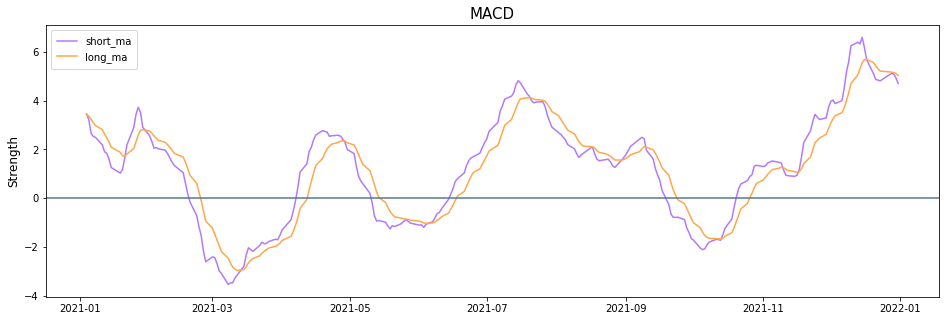

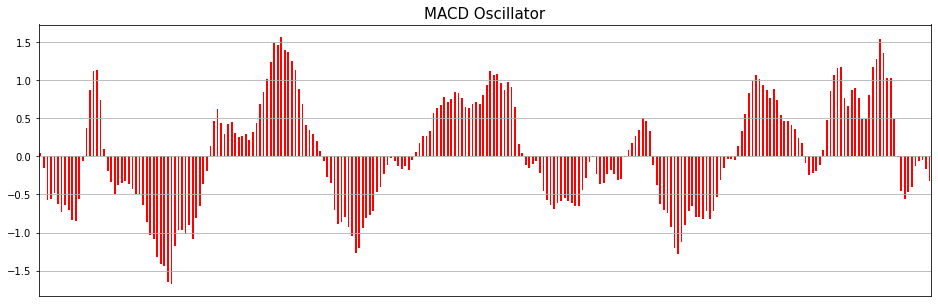

In [15]:
macd(apple_df.loc['2021':'2021'])

### Bollinger Bands  <a id = 3.2> </a> 
[Back to Top](#0)
- Price almost never leaves Bollinger Bands space
    - Price is fluctuating between three standard deviations
- Good indicator as buying/selling signal

In [16]:
def bollinger_bands_plot(stock, std=3):    
    plt.figure(figsize=(16,5))
    plt.style.use('seaborn-whitegrid')
    plt.plot(stock.index, stock.Close, color='#3388cf', label='Price')
    plt.plot(stock.index, stock.ma21, color='#ad6eff', label='Moving Average (21 days)')
    plt.plot(stock.index, stock.ma7, color='#ff6e9d', label='Moving Average (7 days)')
    plt.plot(stock.index, stock.upper_boll_band, color='#ffbd74', alpha=0.3)
    plt.plot(stock.index, stock.lower_boll_band, color='#ffa33f', alpha=0.3)
    plt.fill_between(stock.index, stock.upper_boll_band, stock.lower_boll_band, color='#ffa33f', alpha=0.1, label=f'Bollinger Band ({std} STD)')
    plt.legend(frameon=True, loc=0, ncol=1, fontsize=10, borderpad=.6)
    plt.title('Bollinger Bands', fontsize=15)
    plt.ylabel('Price', fontsize=12)
    plt.xlim([stock.index.min(), stock.index.max()])
    plt.show()

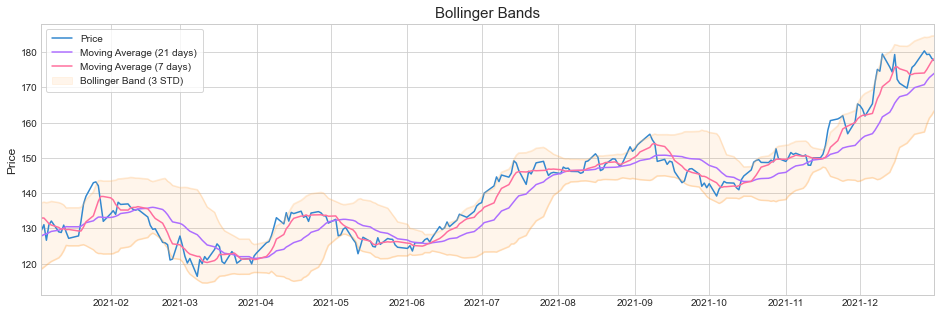

In [17]:
bollinger_bands_plot(apple_df.loc['2021':'2021'])

### RSI - Relative Strength Index <a id = 3.3> </a> 
[Back to Top](#0)
- A momentum indicator that can tell if stock is overbought or oversold
- Ranges from 0 to 100
- When index approaches 30, signal to buy
- When index approaches 70, signal to sell

In [18]:
def rsi(stock):
    plt.figure(figsize=(16,5)) 
    plt.plot(stock.index, stock.rsi, color='#ad6eff')
    plt.xlim([stock.index.min(), stock.index.max()])
    plt.axhline(30, color='#f9989c')
    plt.axhline(70, color='#60e8ad')
    plt.title('RSI', fontsize=15)
    plt.ylabel('%', fontsize=12)
    plt.ylim([0, 100])
    plt.show()

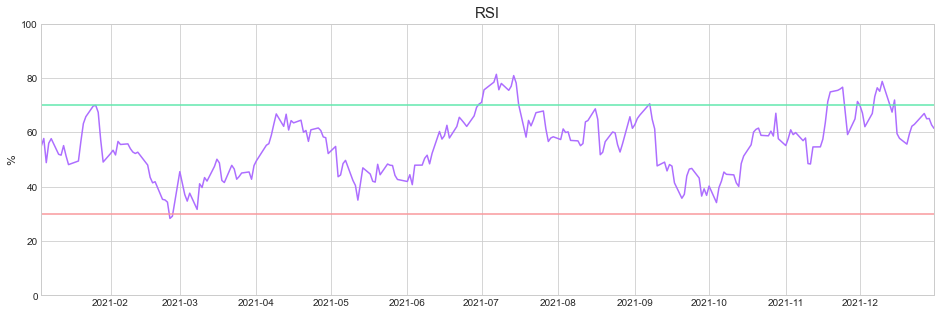

In [19]:
rsi(apple_df.loc['2021':'2021'])

### Normal Distribution <a id = 3.4> </a> 
[Back to Top](#0)
- ML algorithms require normal distribution of data to work well
- Target var `return` mostly normal

In [20]:
apple_df.head()

,High,Low,Open,Close,Volume,Adj Close,upper_boll_band,lower_boll_band,macd,signal,rsi,ma7,ma21,momentum,change,volatility,return
Date,,,,,,,,,,,,,,,,,
2000-01-03,1.004464,0.907924,0.936384,0.999442,535796800.0,0.855797,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,0.0673
2000-01-04,0.987723,0.903460,0.966518,0.915179,512377600.0,0.783644,NaN,NaN,-0.006722,-0.001344,NaN,NaN,NaN,NaN,-0.084263,0.059583,-0.0531
2000-01-05,0.987165,0.919643,0.926339,0.928571,778321600.0,0.795111,NaN,NaN,-0.010843,-0.003244,NaN,NaN,NaN,NaN,0.013392,0.044683,0.0024
2000-01-06,0.955357,0.848214,0.947545,0.848214,767972800.0,0.726304,NaN,NaN,-0.020359,-0.006667,NaN,NaN,NaN,-2.000558,-0.080357,0.061924,-0.1048
2000-01-07,0.901786,0.852679,0.861607,0.888393,460734400.0,0.760708,NaN,NaN,-0.024377,-0.010209,NaN,NaN,NaN,-2.084821,0.040179,0.055008,0.0311


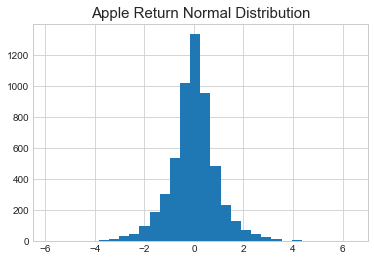

In [21]:
z = lambda x: (x - x.mean()) / x.std()

plt.hist(z(apple_df['return']), bins=30)
plt.title('Apple Return Normal Distribution', fontsize=15)
plt.show()

<Figure size 1152x360 with 0 Axes>

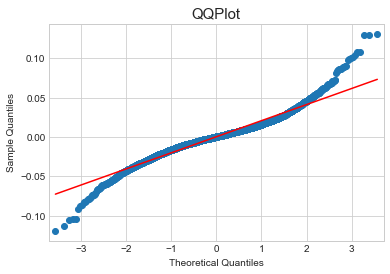

In [22]:
plt.figure(figsize=(16,5))
sm.qqplot(apple_df['return'], line='s', scale=1)
plt.title('QQPlot', fontsize=15);

## Model <a id = 4> </a> 
[Back to Top](#0)
- **Base Model:** Buy and Hold
- **Technical Indicator:** Bollinger Bands and MACD
- **NN Model:** LSTM
- **Deep Reinforcement Learning (DRL):** Evolution Strategy

### Base Model <a id = 4.0> </a> 

In [23]:
initial_cap = 10000

class BuyAndHold_Buy(bt.Strategy):
    def start(self):
        # set the starting cash
        self.val_start = self.broker.get_cash() 
    def nextstart(self):
        # Buy stocks with all the available cash
        size = int(self.val_start / self.data)
        self.buy(size=size)
    def stop(self):
        # calculate the actual returns
        self.roi = (self.broker.get_value() / self.val_start) - 1.0
        globals()[f'base_ROI_{ticker_name}'] = round(self.roi*100,2)
        print("ROI: %.2f, Cash: %.2f" % (100.0 * self.roi, self.broker.get_value()))
        
for ticker_name in ticker_list:
    print(f'\n{ticker_name}')
    data = bt.feeds.PandasData(dataname=yf.download(ticker_name, start=start, end=end, auto_adjust=True))
    cerebro = bt.Cerebro()
    cerebro.adddata(data)
    cerebro.addstrategy(BuyAndHold_Buy, "HODL")
    cerebro.broker.setcash(initial_cap)
    cerebro.run()


MSFT
[*********************100%***********************]  1 of 1 completed
ROI: 54.76, Cash: 15476.29

XOM
[*********************100%***********************]  1 of 1 completed
ROI: 0.00, Cash: 10000.00

CVX
[*********************100%***********************]  1 of 1 completed
ROI: 0.00, Cash: 10000.00

TSLA
[*********************100%***********************]  1 of 1 completed
ROI: 61.90, Cash: 16189.56

SPY
[*********************100%***********************]  1 of 1 completed
ROI: 30.90, Cash: 13090.21

AAPL
[*********************100%***********************]  1 of 1 completed
ROI: 41.46, Cash: 14145.76


### Technical Indicator - Bollinger Bands <a id = 4.1> </a> 
[Back to Top](#0)

In [24]:
def trading_history(stock, net, std=2):    
    
    # Bollinger band plot with EMA and original historical data
    plt.figure(figsize=(16,5))
    plt.style.use('seaborn-whitegrid')
    plt.plot(stock.index, stock.Close, color='#3388cf', label='Price')
    plt.plot(stock.index, stock.ma21, color='#ad6eff', label='Moving Average (21 days)')
    plt.plot(stock.index, stock.upper_boll_band, color='#ffbd74', alpha=0.3)
    plt.plot(stock.index, stock.lower_boll_band, color='#ffa33f', alpha=0.3)
    plt.fill_between(stock.index, stock.upper_boll_band, stock.lower_boll_band, color='#ffa33f', alpha=0.1, label='Bollinger Band ({} STD)'.format(std))
    
    for i in net:
        if i[2] == 1: color = '#ff005e'
        else: color = '#4bd81d'
        plt.plot_date(i[0], i[1], color=color)
        
    plt.plot_date([],[],label='Buy', c='#ff005e')
    plt.plot_date([],[],label='Sell', c='#4bd81d')
        
    plt.legend(frameon=True, loc=0, ncol=1, fontsize=10, borderpad=.6)
    plt.title('Trading History', fontsize=15)
    plt.ylabel('Price', fontsize=12)
    plt.xlim([stock.index.min(), stock.index.max()])
    plt.show()


MSFT
Number of Trades: 24
Time Frame: 351 days
Initial Capital: $10000
Percentage Gain: $710.08 | 7.1%


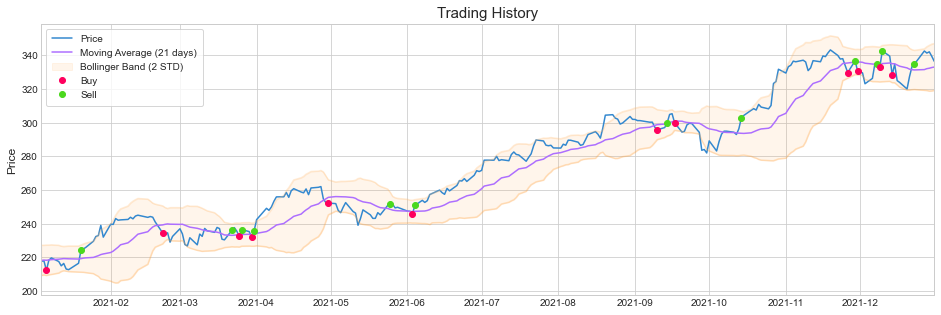


XOM
Number of Trades: 17
Time Frame: 261 days
Initial Capital: $10000
Percentage Gain: $-91.23 | -0.91%


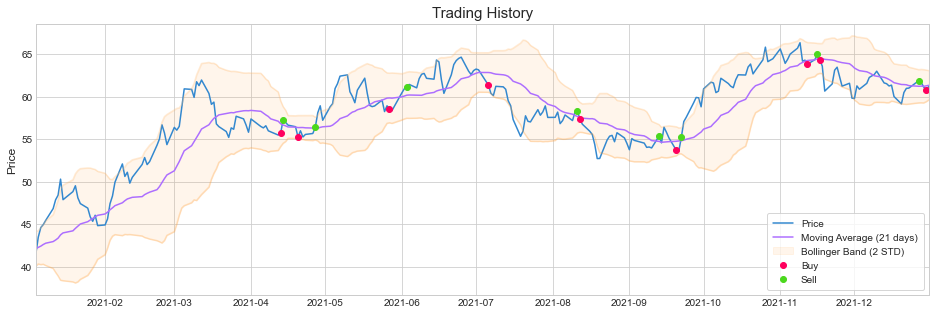


CVX
Number of Trades: 24
Time Frame: 327 days
Initial Capital: $10000
Percentage Gain: $2077.52 | 20.78%


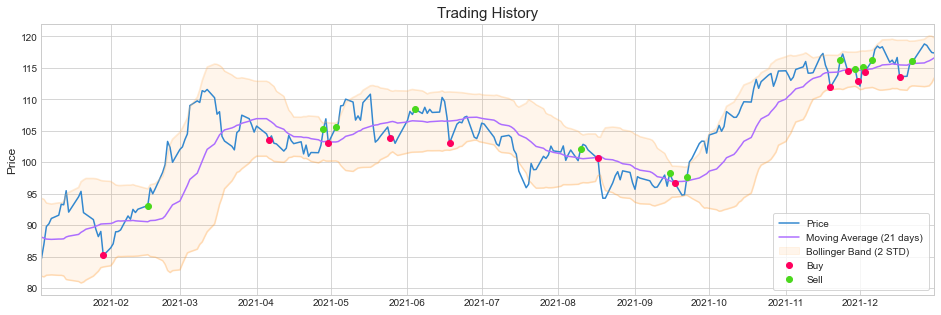


TSLA
Number of Trades: 7
Time Frame: 302 days
Initial Capital: $10000
Percentage Gain: $-2973.40 | -29.73%


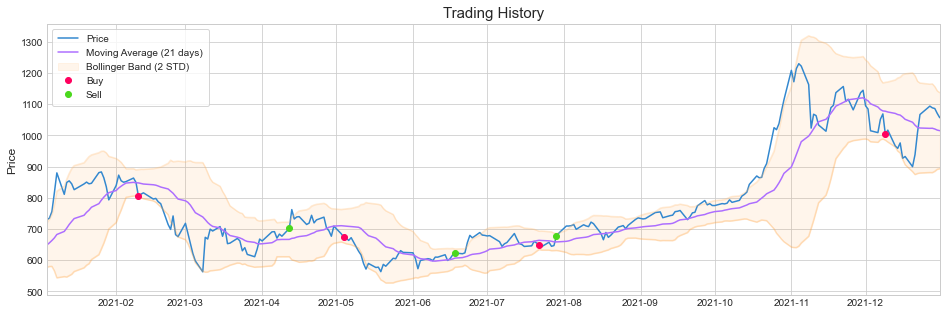


SPY
Number of Trades: 30
Time Frame: 351 days
Initial Capital: $10000
Percentage Gain: $-1201.86 | -12.02%


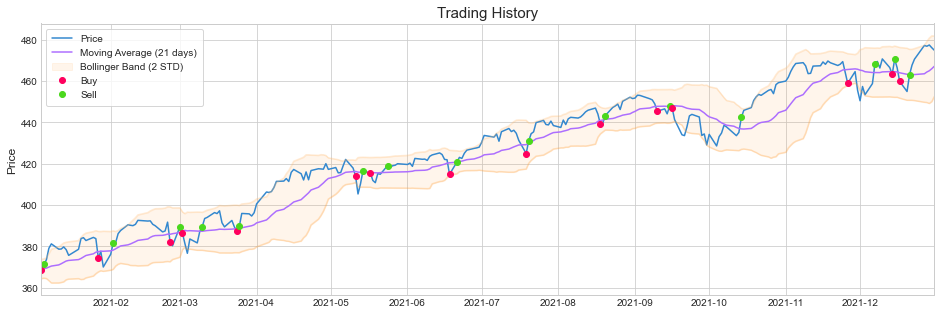


AAPL
Number of Trades: 14
Time Frame: 301 days
Initial Capital: $10000
Percentage Gain: $-850.61 | -8.51%


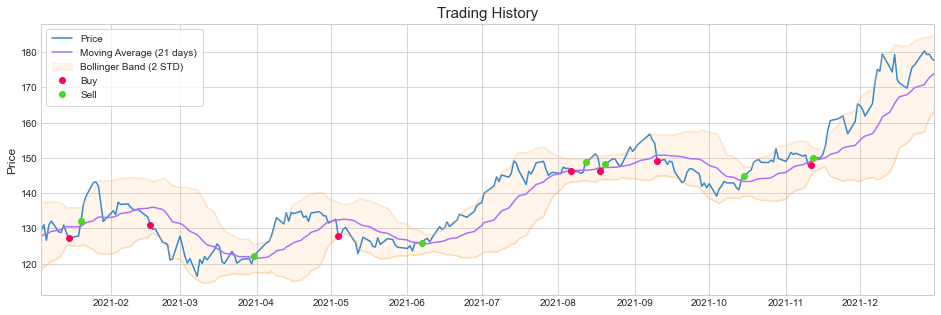

In [25]:
def bb_trading(stock, budget=10000, u=0.03, l=0.03, show_graph=True, show_return=True):
    
    money = budget
    stock = stock.reset_index()
    net = []
    for i in range(len(stock)):
        today = stock.iloc[i]
        
        # Buy
        if (today.Close < today.ma21) and (abs(1 - today.Close / today.lower_boll_band) < u):
            if money > 0:
                stock_amt = int(money / today.Close)
                money = 0
                net.append([today.Date, today.Close, 1, stock_amt * today.Close])

        # Sell        
        if (today.Close > today.ma21) and (abs(1 - today.upper_boll_band / today.Close) < l):
            if money == 0:
                money = stock_amt * today.Close
                stock_amt = 0
                net.append([today.Date, today.Close, 0, money])
        
    profit = net[-1][3] - budget
    
    if show_return == True:
        print('Number of Trades: {}'.format(len(net)))
        print('Time Frame: {} days'.format((net[-1][0] - net[0][0]).days))
        print(f'Initial Capital: ${budget}')
        print('Percentage Gain: ${:.2f} | {}%'.format(profit, round(profit/budget*100, 2)))

    if show_graph == True:
        trading_history(stock.set_index('Date'), net)

    return profit, net, budget

for ticker_name in ticker_list:
    print(f'\n{ticker_name}')
    A = bb_trading(stocks[ticker_name].loc['2021':'2021'], u=0.03, l=0.03);
    globals()[f'bb_ROI_{ticker_name}'] = round(A[0]/A[2]*100, 2)

### Technical Indicator - MACD <a id = 4.2> </a> 
[Back to Top](#0)


MSFT
Number of Trades: 21
Time Frame: 340 days
Initial Capital: $10000
Profit: $1300.85 | 13.01%


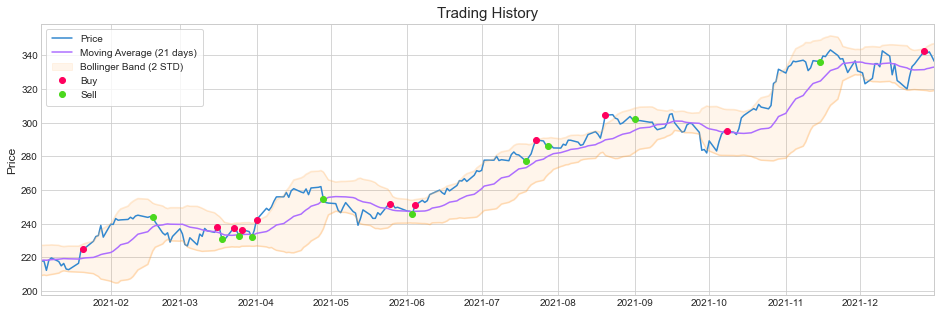


XOM
Number of Trades: 17
Time Frame: 354 days
Initial Capital: $10000
Profit: $2192.33 | 21.92%


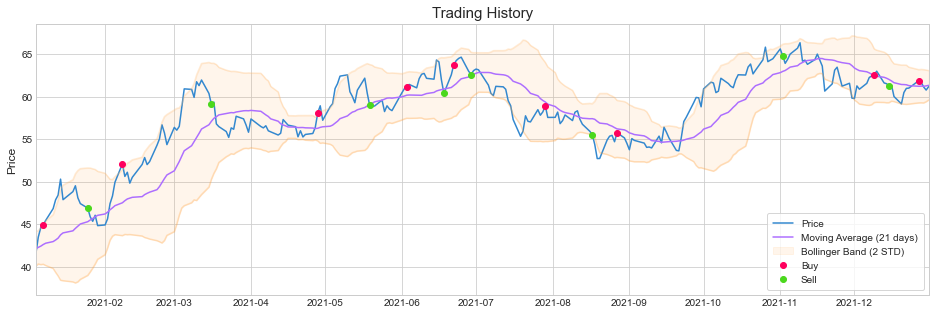


CVX
Number of Trades: 19
Time Frame: 355 days
Initial Capital: $10000
Profit: $1026.08 | 10.26%


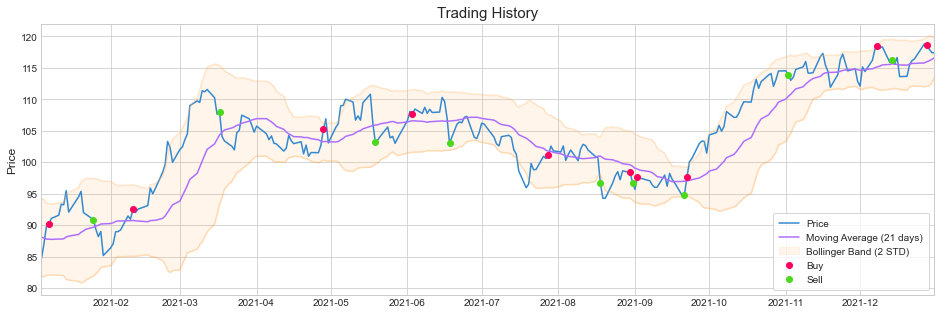


TSLA
Number of Trades: 19
Time Frame: 290 days
Initial Capital: $10000
Profit: $-3436.36 | -34.36%


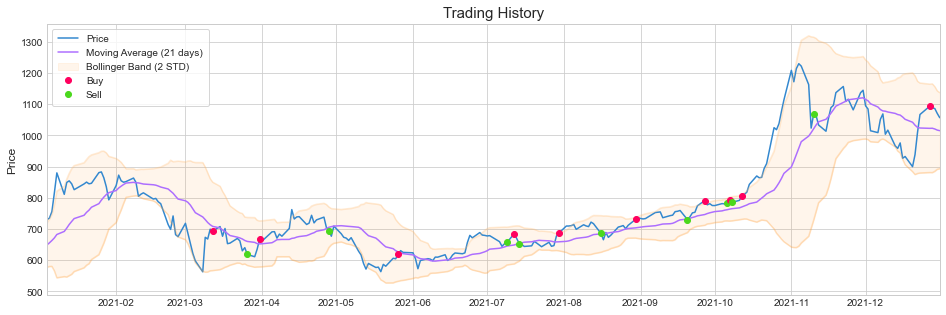


SPY
Number of Trades: 29
Time Frame: 350 days
Initial Capital: $10000
Profit: $-3882.20 | -38.82%


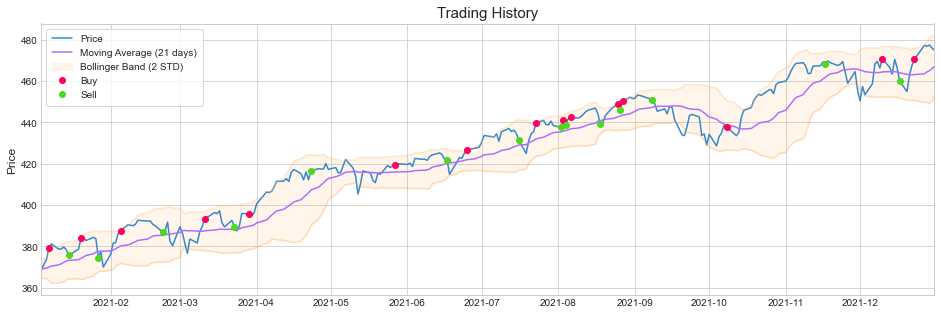


AAPL
Number of Trades: 12
Time Frame: 329 days
Initial Capital: $10000
Profit: $2835.50 | 28.35%


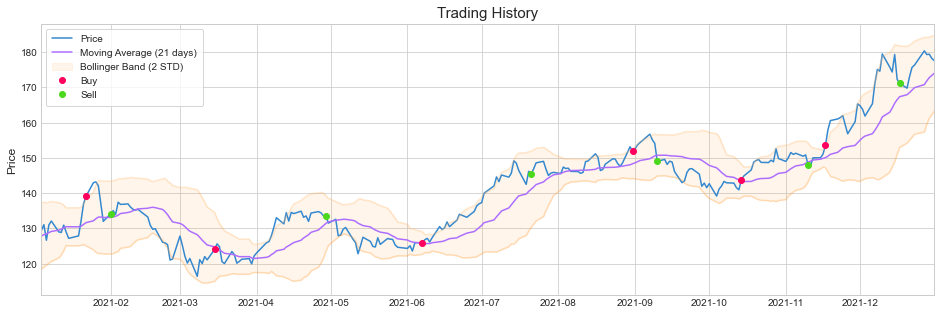

In [26]:
def macd_trading(stock, budget=10000, show_graph=True, show_return=True):
    
    state_check = lambda x, y: 1 if x > y else 0
    stock = stock.reset_index()    
    money = budget
    prev_state = state_check(stock.loc[0].macd, stock.loc[0].signal)
    stock_amt = 0
    net = []

    for i in range(1, len(stock)):

        today = stock.iloc[i]
        state = state_check(today.macd, today.signal)

        if state != prev_state:

            # BUY
            if (today.macd > today.signal) and (money != 0):
                stock_amt = int(money / today.Close)
                money = 0
                net.append([today.Date, today.Close, 1, stock_amt * today.Close])

            # SELL
            if (today.macd < today.signal) and (stock_amt != 0):
                money = stock_amt * today.Close
                stock_amt = 0
                net.append([today.Date, today.Close, 0, money])

        prev_state = state
    
    profit = net[-1][3] - budget
    
    if show_return == True:
        print('Number of Trades: {}'.format(len(net)))
        print('Time Frame: {} days'.format((net[-1][0] - net[0][0]).days))
        print(f'Initial Capital: ${budget}')
        print('Profit: ${:.2f} | {}%'.format(profit, round(profit/budget*100, 2)))

    if show_graph == True:
        trading_history(stock.set_index('Date'), net)

    return profit, net, budget


for ticker_name in ticker_list:
    print(f'\n{ticker_name}')
    A = macd_trading(stocks[ticker_name].loc['2021':'2021']);
    globals()[f'macd_ROI_{ticker_name}'] = round(A[0]/A[2]*100, 2)

### LSTM <a id = 4.3> </a> 
[Back to Top](#0)


MSFT
[*********************100%***********************]  1 of 1 completed
Epoch 1/5
21/21 [==============================] - 11s 80ms/step - loss: 0.0530
Epoch 2/5
21/21 [==============================] - 2s 72ms/step - loss: 0.0111
Epoch 3/5
21/21 [==============================] - 1s 67ms/step - loss: 0.0065
Epoch 4/5
21/21 [==============================] - 2s 75ms/step - loss: 0.0059
Epoch 5/5
21/21 [==============================] - 1s 67ms/step - loss: 0.0051


RMSE: 7.6446748946869585


Initial Capital: $10000
Final Balance: $12290.91
Percentage Gain: 22.91%


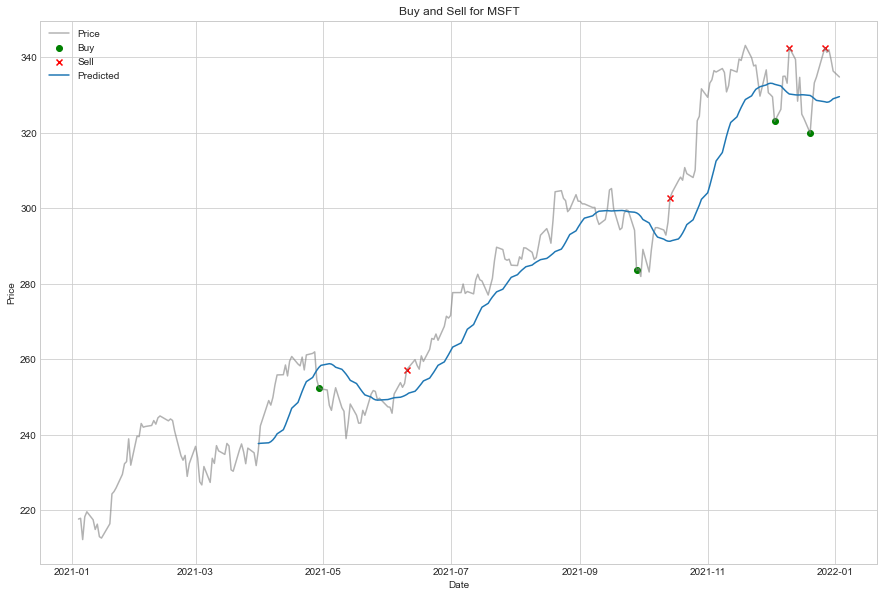


XOM
[*********************100%***********************]  1 of 1 completed
Epoch 1/5
21/21 [==============================] - 6s 69ms/step - loss: 0.0743
Epoch 2/5
21/21 [==============================] - 1s 67ms/step - loss: 0.0126
Epoch 3/5
21/21 [==============================] - 1s 66ms/step - loss: 0.0136
Epoch 4/5
21/21 [==============================] - 1s 70ms/step - loss: 0.0097
Epoch 5/5
21/21 [==============================] - 1s 67ms/step - loss: 0.0083


RMSE: 1.4090831712111933


Initial Capital: $10000
Final Balance: $12296.98
Percentage Gain: 22.97%


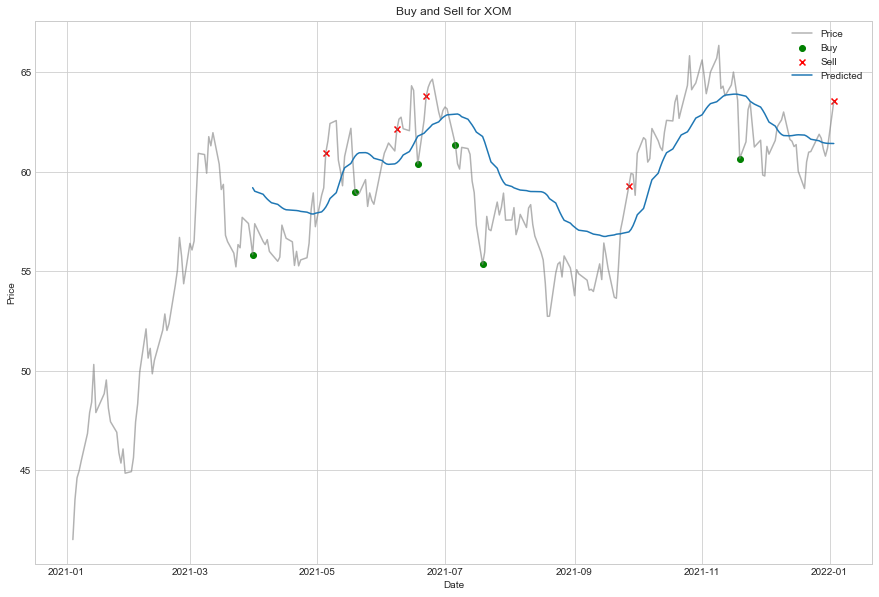


CVX
[*********************100%***********************]  1 of 1 completed
Epoch 1/5
21/21 [==============================] - 6s 68ms/step - loss: 0.0501
Epoch 2/5
21/21 [==============================] - 1s 67ms/step - loss: 0.0175
Epoch 3/5
21/21 [==============================] - 1s 68ms/step - loss: 0.0139
Epoch 4/5
21/21 [==============================] - 1s 67ms/step - loss: 0.0104
Epoch 5/5
21/21 [==============================] - 1s 68ms/step - loss: 0.0093


RMSE: 6.087406291337523


Initial Capital: $10000
Final Balance: $11420.28
Percentage Gain: 14.20%


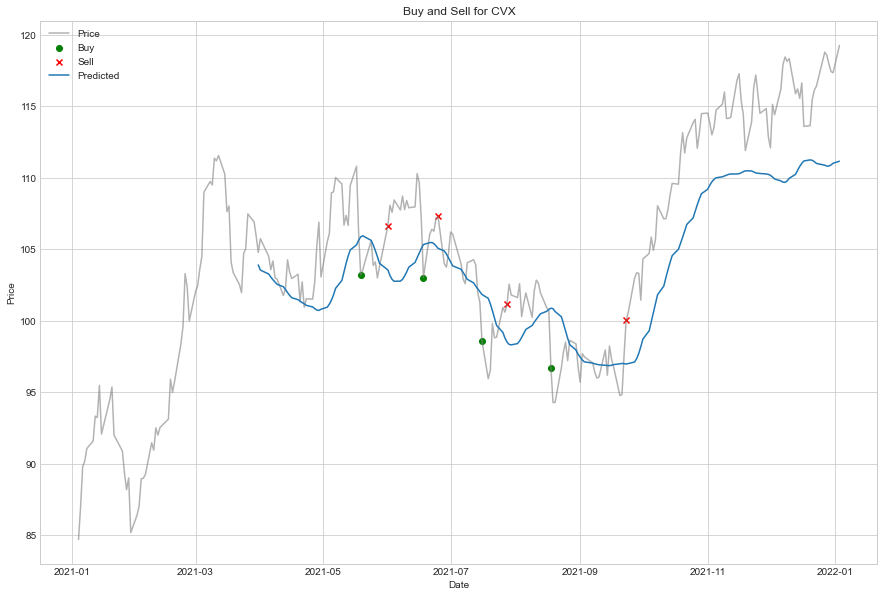


TSLA
[*********************100%***********************]  1 of 1 completed
Epoch 1/5
21/21 [==============================] - 6s 68ms/step - loss: 0.0480
Epoch 2/5
21/21 [==============================] - 1s 66ms/step - loss: 0.0145
Epoch 3/5
21/21 [==============================] - 1s 66ms/step - loss: 0.0121
Epoch 4/5
21/21 [==============================] - 1s 67ms/step - loss: 0.0094
Epoch 5/5
21/21 [==============================] - 1s 68ms/step - loss: 0.0113


RMSE: 85.3577876242156


Initial Capital: $10000
Final Balance: $12758.54
Percentage Gain: 27.59%


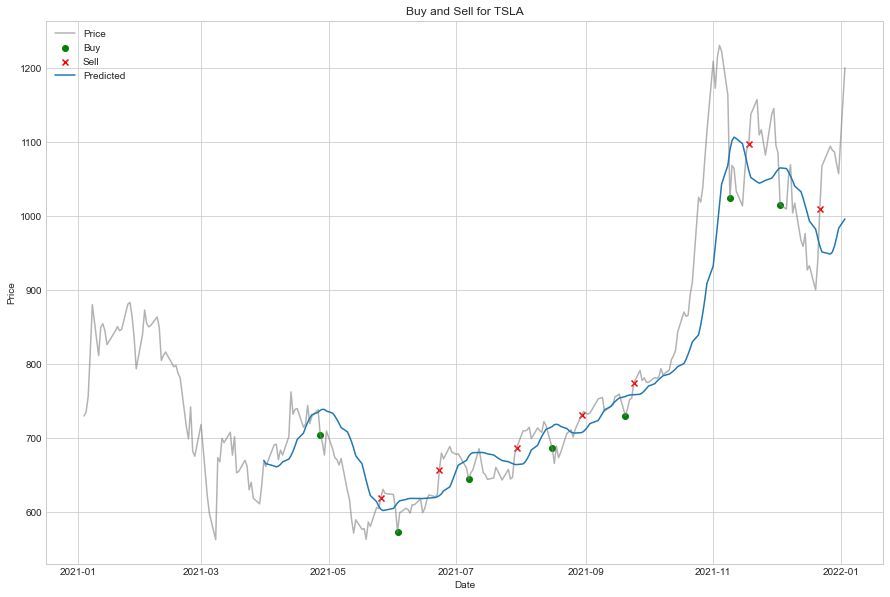


SPY
[*********************100%***********************]  1 of 1 completed
Epoch 1/5
21/21 [==============================] - 6s 68ms/step - loss: 0.0404
Epoch 2/5
21/21 [==============================] - 1s 70ms/step - loss: 0.0058
Epoch 3/5
21/21 [==============================] - 1s 66ms/step - loss: 0.0048
Epoch 4/5
21/21 [==============================] - 1s 67ms/step - loss: 0.0036
Epoch 5/5
21/21 [==============================] - 1s 67ms/step - loss: 0.0049


RMSE: 10.535850178363283


Initial Capital: $10000
Final Balance: $11490.16
Percentage Gain: 14.90%


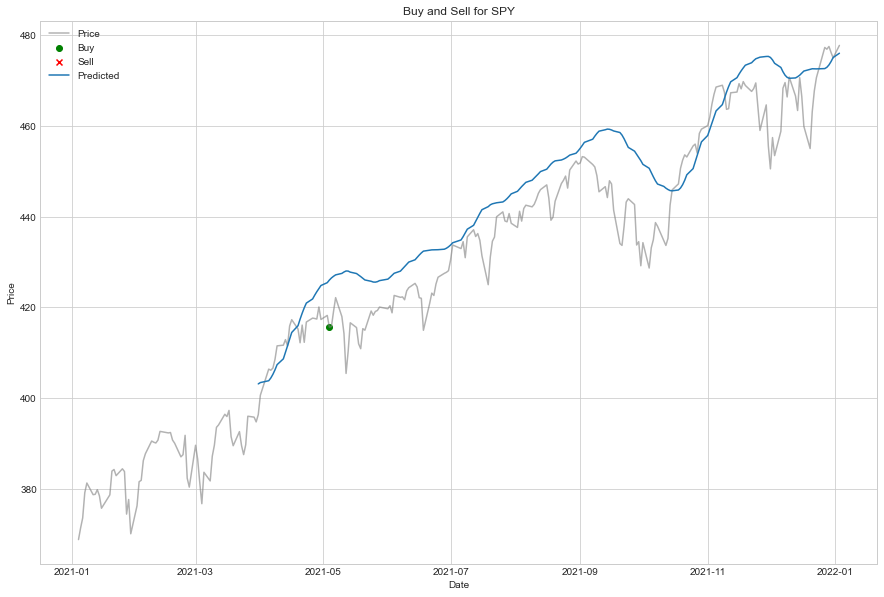


AAPL
[*********************100%***********************]  1 of 1 completed
Epoch 1/5
21/21 [==============================] - 7s 97ms/step - loss: 0.0295
Epoch 2/5
21/21 [==============================] - 1s 67ms/step - loss: 0.0077
Epoch 3/5
21/21 [==============================] - 1s 69ms/step - loss: 0.0050
Epoch 4/5
21/21 [==============================] - 1s 66ms/step - loss: 0.0058
Epoch 5/5
21/21 [==============================] - 1s 67ms/step - loss: 0.0044


RMSE: 12.713746898253344


Initial Capital: $10000
Final Balance: $10405.20
Percentage Gain: 4.05%


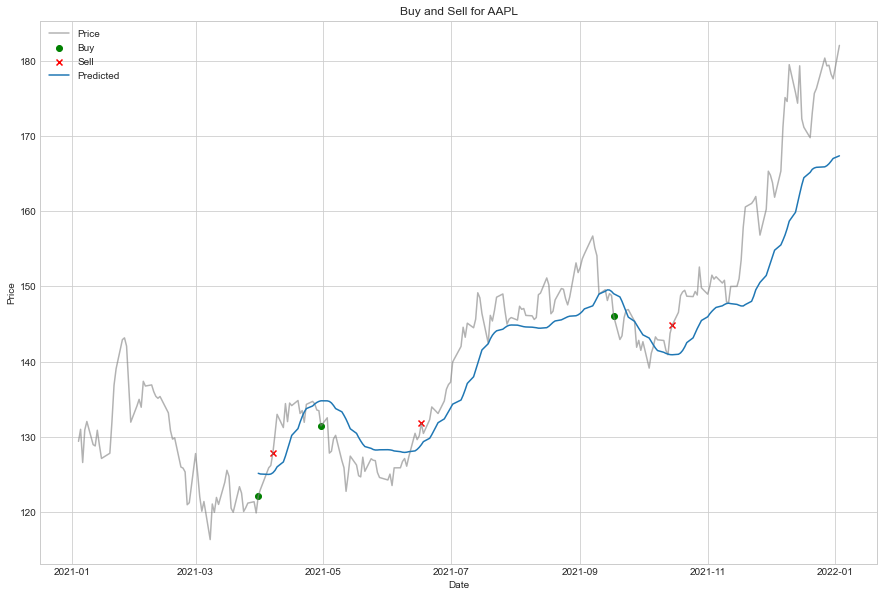

In [55]:
for ticker_name in ticker_list:
    print(f'\n{ticker_name}')
    %run modelling/agent_lstm.ipynb
    globals()[f'lstm_ROI_{ticker_name}'] = round(100*(agent.total_balance()-invest)/invest, 2)

### DRL - Evolution Strategy <a id = 4.4> </a> 
[Back to Top](#0)


MSFT
[*********************100%***********************]  1 of 1 completed
iter 10. reward: 4.746500
iter 20. reward: 5.334200
iter 30. reward: 3.442700
iter 40. reward: 11.416799
iter 50. reward: 12.975700
iter 60. reward: 10.043601
iter 70. reward: 8.693501
iter 80. reward: 12.317201
iter 90. reward: 10.534099
iter 100. reward: 14.259599
iter 110. reward: 11.569599
iter 120. reward: 5.360900
iter 130. reward: 15.620100
iter 140. reward: 17.953400
iter 150. reward: 12.920500
iter 160. reward: 17.195500
iter 170. reward: 18.560201
iter 180. reward: 19.794800
iter 190. reward: 20.489300
iter 200. reward: 22.374300
iter 210. reward: 20.297900
iter 220. reward: 8.091600
iter 230. reward: 23.160700
iter 240. reward: 26.816199
iter 250. reward: 25.393400
iter 260. reward: 22.263401
iter 270. reward: 24.828800
iter 280. reward: 24.292200
iter 290. reward: 26.359100
iter 300. reward: 27.952400
iter 310. reward: 26.693701
iter 320. reward: 23.565901
iter 330. reward: 25.008200
iter 340. reward

day 190: buy 1 unit at price 288.760010, total balance 5163.070023
day 191: buy 1 unit at price 293.109985, total balance 4869.960037
day 193, sell 1 unit at price 294.850006, investment 14.123712 %, total balance 5164.810043,
day 197: buy 1 unit at price 302.750000, total balance 4862.060043
day 199: buy 1 unit at price 307.290009, total balance 4554.770035
day 200, sell 1 unit at price 308.230011, investment 17.362832 %, total balance 4863.000046,
day 201: buy 1 unit at price 307.410004, total balance 4555.590042
day 204, sell 1 unit at price 308.130005, investment 16.052124 %, total balance 4863.720047,
day 205, sell 1 unit at price 310.109985, investment 16.281069 %, total balance 5173.830032,
day 206, sell 1 unit at price 323.170013, investment 21.941750 %, total balance 5497.000046,
day 207, sell 1 unit at price 324.350006, investment 15.868258 %, total balance 5821.350052,
day 208, sell 1 unit at price 331.619995, investment 18.022629 %, total balance 6152.970047,
day 209, sell 

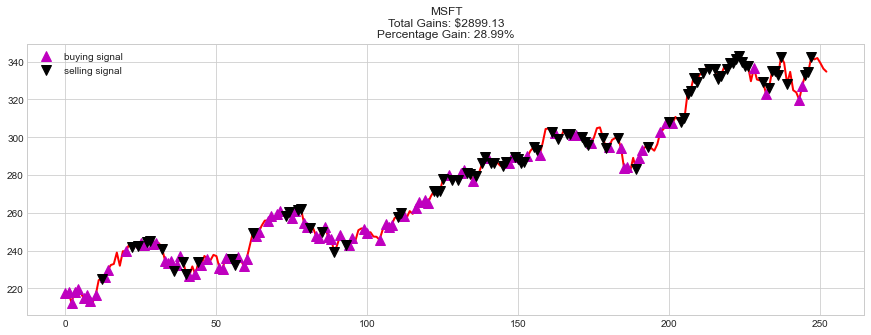


XOM
[*********************100%***********************]  1 of 1 completed
iter 10. reward: 0.520300
iter 20. reward: 0.758200
iter 30. reward: 1.030600
iter 40. reward: 0.530700
iter 50. reward: 1.700800
iter 60. reward: 1.483800
iter 70. reward: 1.605400
iter 80. reward: 1.562900
iter 90. reward: 1.523200
iter 100. reward: 1.775200
iter 110. reward: 1.194400
iter 120. reward: 2.086400
iter 130. reward: 1.988800
iter 140. reward: 2.284100
iter 150. reward: 2.332200
iter 160. reward: 2.195600
iter 170. reward: 3.015000
iter 180. reward: 2.013500
iter 190. reward: 2.141900
iter 200. reward: 0.455400
iter 210. reward: 2.472200
iter 220. reward: 2.401600
iter 230. reward: 2.814100
iter 240. reward: 2.373200
iter 250. reward: 2.557000
iter 260. reward: 2.714400
iter 270. reward: 2.933800
iter 280. reward: 3.032500
iter 290. reward: 2.960700
iter 300. reward: 3.059300
iter 310. reward: 2.696400
iter 320. reward: 3.259700
iter 330. reward: 3.339900
iter 340. reward: 3.168600
iter 350. reward:

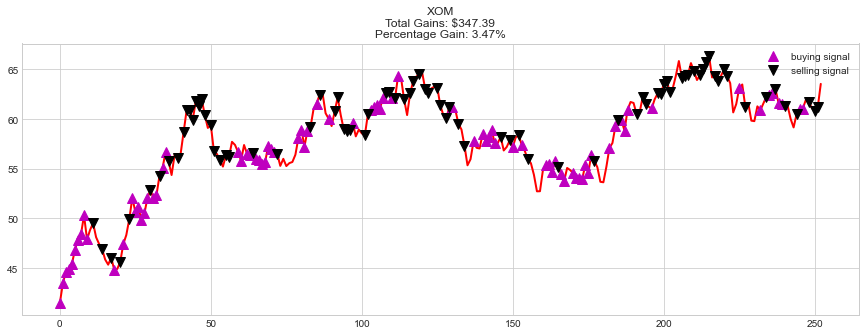


CVX
[*********************100%***********************]  1 of 1 completed
iter 10. reward: 1.312699
iter 20. reward: -1.239300
iter 30. reward: 2.625200
iter 40. reward: 3.168100
iter 50. reward: 2.880900
iter 60. reward: 3.377900
iter 70. reward: 3.603500
iter 80. reward: 2.838200
iter 90. reward: 3.365700
iter 100. reward: 4.332100
iter 110. reward: 3.754300
iter 120. reward: 3.691700
iter 130. reward: 4.005300
iter 140. reward: 4.049200
iter 150. reward: 4.528800
iter 160. reward: 4.563800
iter 170. reward: 5.043500
iter 180. reward: 4.892900
iter 190. reward: 5.332500
iter 200. reward: 6.243300
iter 210. reward: 5.337000
iter 220. reward: 6.178700
iter 230. reward: 6.247600
iter 240. reward: 5.321500
iter 250. reward: 6.339800
iter 260. reward: 4.648800
iter 270. reward: 6.246200
iter 280. reward: 6.402400
iter 290. reward: 6.382500
iter 300. reward: 6.672400
iter 310. reward: 5.713100
iter 320. reward: 6.415700
iter 330. reward: 6.189400
iter 340. reward: 6.428600
iter 350. reward

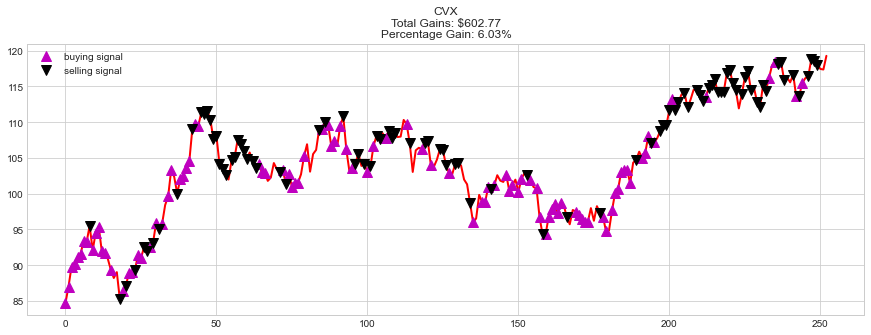


TSLA
[*********************100%***********************]  1 of 1 completed
iter 10. reward: 15.938096
iter 20. reward: 23.846296
iter 30. reward: 41.742794
iter 40. reward: 55.486294
iter 50. reward: 53.644194
iter 60. reward: 55.978095
iter 70. reward: 71.329297
iter 80. reward: 73.423495
iter 90. reward: 69.970696
iter 100. reward: 75.649096
iter 110. reward: 67.404896
iter 120. reward: 77.605094
iter 130. reward: 77.339894
iter 140. reward: 78.136594
iter 150. reward: 81.106197
iter 160. reward: 81.112996
iter 170. reward: 79.364294
iter 180. reward: 82.480996
iter 190. reward: 82.097896
iter 200. reward: 79.897194
iter 210. reward: 83.961895
iter 220. reward: 81.408094
iter 230. reward: 85.709496
iter 240. reward: 87.806295
iter 250. reward: 83.698395
iter 260. reward: 88.026794
iter 270. reward: 85.822195
iter 280. reward: 85.941594
iter 290. reward: 90.531096
iter 300. reward: 90.910596
iter 310. reward: 90.225996
iter 320. reward: 91.410596
iter 330. reward: 92.121897
iter 340. 

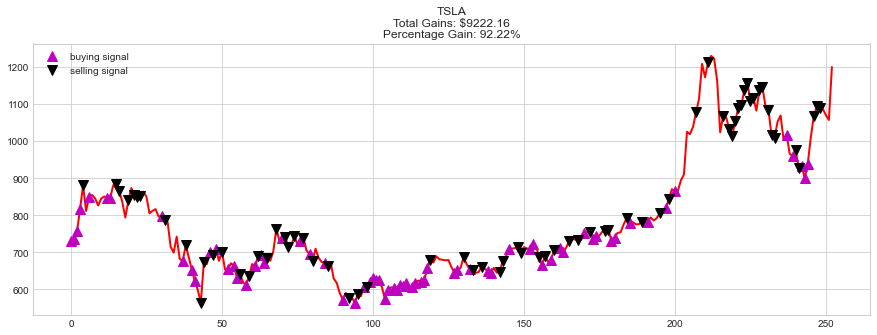


SPY
[*********************100%***********************]  1 of 1 completed
iter 10. reward: 0.090599
iter 20. reward: -0.581300
iter 30. reward: 5.617499
iter 40. reward: 3.202099
iter 50. reward: 1.024799
iter 60. reward: 5.137701
iter 70. reward: 6.329901
iter 80. reward: 2.606401
iter 90. reward: 9.395000
iter 100. reward: 5.797100
iter 110. reward: 8.285099
iter 120. reward: 8.884500
iter 130. reward: 6.166600
iter 140. reward: 9.523601
iter 150. reward: 9.376600
iter 160. reward: 9.261900
iter 170. reward: 7.989700
iter 180. reward: 10.154701
iter 190. reward: 11.060700
iter 200. reward: 10.607401
iter 210. reward: 9.663800
iter 220. reward: 7.932501
iter 230. reward: 14.758400
iter 240. reward: 14.779800
iter 250. reward: 2.421800
iter 260. reward: 15.586200
iter 270. reward: 14.923200
iter 280. reward: 12.739500
iter 290. reward: 15.628000
iter 300. reward: 15.063800
iter 310. reward: 16.695700
iter 320. reward: 9.309901
iter 330. reward: 16.929700
iter 340. reward: 16.490101
ite

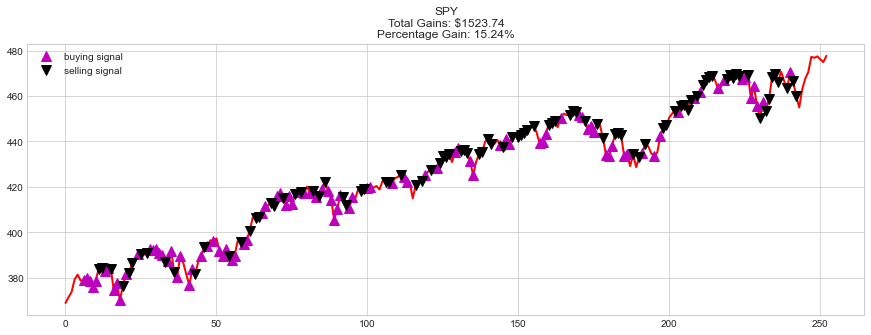


AAPL
[*********************100%***********************]  1 of 1 completed
iter 10. reward: 1.323800
iter 20. reward: 3.280200
iter 30. reward: 2.637500
iter 40. reward: 3.348300
iter 50. reward: 4.079700
iter 60. reward: 3.675000
iter 70. reward: 6.153001
iter 80. reward: 7.484901
iter 90. reward: 7.072201
iter 100. reward: 6.391701
iter 110. reward: 5.017901
iter 120. reward: 2.464301
iter 130. reward: 8.042301
iter 140. reward: 7.223901
iter 150. reward: 4.541401
iter 160. reward: 10.961801
iter 170. reward: 10.880701
iter 180. reward: 11.840701
iter 190. reward: 12.537501
iter 200. reward: 12.566201
iter 210. reward: 12.431601
iter 220. reward: 11.962201
iter 230. reward: 7.280601
iter 240. reward: 7.835301
iter 250. reward: 11.649001
iter 260. reward: 4.667301
iter 270. reward: 13.000601
iter 280. reward: 11.031101
iter 290. reward: 13.168101
iter 300. reward: 12.126501
iter 310. reward: 8.983701
iter 320. reward: 14.017501
iter 330. reward: 14.007201
iter 340. reward: 13.504401
i

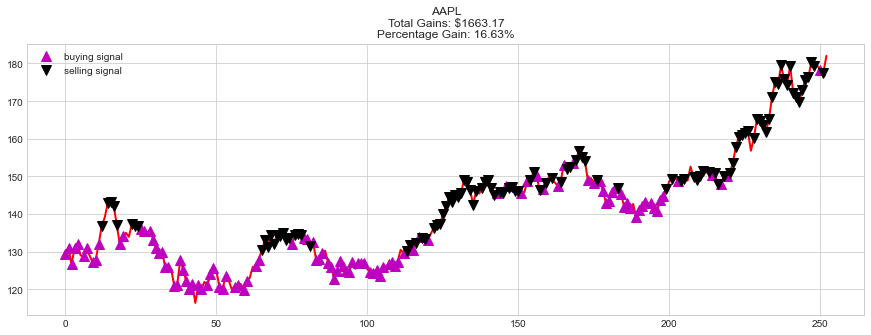

In [28]:
for ticker_name in ticker_list:
    print(f'\n{ticker_name}')
    %run modelling/agent_es.ipynb
    globals()[f'es_ROI_{ticker_name}'] = round(invest, 2)

## Results <a id = 5> </a> 
[Back to Top](#0)

In [56]:
algo_list = ['base_ROI_', 'bb_ROI_', 'macd_ROI_', 'lstm_ROI_', 'es_ROI_']
gen_list = []

for a in algo_list:
    for t in ticker_list:
        gen_list.append(a+t)

models_list = ['Base Model', 'Bollinger Bands', 'MACD', 'LSTM', 'Evolution Strategy']

def average(y):
    return str(round(sum([float(x.split(' ')[0]) for x in y])/len(y),1))+' %'

base = [f'{eval(x):.1f} %' for x in gen_list if algo_list[0] in x]
base_ave = average(base)

bb = [f'{eval(x):.1f} %' for x in gen_list if algo_list[1] in x]
bb_ave = average(bb)

macd = [f'{eval(x):.1f} %' for x in gen_list if algo_list[2] in x]
macd_ave = average(macd)

lstm = [f'{eval(x):.1f} %' for x in gen_list if algo_list[3] in x]
lstm_ave = average(lstm)

es = [f'{eval(x):.1f} %' for x in gen_list if algo_list[4] in x]
es_ave = average(es)

In [176]:
fig = go.Figure(data=[go.Table(
    columnwidth = [300, 400],
    header=dict(values=['']+models_list,
                line_color='darkslategray',
                fill_color='royalblue',
                align='center',
                font=dict(color='white', size=14)
               ),
    cells=dict(values=[
                 ticker_list+['<b>Average</b>'],
                 base+['<b>'+base_ave+'</b>'], 
                 bb+['<b>'+bb_ave+'</b>'],
                 macd+['<b>'+macd_ave+'</b>'],
                 lstm+['<b>'+lstm_ave+'</b>'],
                 es+['<b>'+es_ave+'</b>']
                 ],
               line_color='darkslategray',
               fill_color='lightcyan',
               align='center',
               font=dict(color='black', size=12)
              )
)])
fig.show()

## Conclusion <a id = 6> </a> 
[Back to Top](#0)

- **Base model (buy and hold strategy)** on average performed the best with **average ROI of 31.5%**
- Technical indicators Bollinger Bands and MACD did very poorly
- Machine learning models fared better compared to technical indicators
- The stock market is a very volatile and complex system
- Historical data is not enough to explain its behavior


## Future Work <a id = 7> </a> 
[Back to Top](#0)

To improve our predictions, the below could be performed for future considerations:
- Continue refining the hyperparameters of current models
- Utilize other models such as ADX (Average Directional Movement Index) and other DRL models
- Fundamental analysis
- Sentiment analysis (twitter, news, social media etc.)
- Local/global economy analysis

## References <a id = 8> </a> 
[Back to Top](#0)

- Turin, A. (2020, March 8). Machine Learning for day trading. Medium. Retrieved March 2, 2022, from towardsdatascience.com/machine-learning-for-day-trading-27c08274df54.

- Jansen, Stefan. “Machine Learning for Algorithmic Trading.” GitHub, PacktPublishing, github.com/PacktPublishing/Machine-Learning-for-Algorithmic-Trading-Second-Edition.

- T.M. “Quant-Trading.” GitHub, 1 Mar. 2022, github.com/je-suis-tm/quant-trading. Accessed 2 Mar. 2022.

- Dector, Aldo. “Moving-Average-Trading-Strategy-With-Python.” GitHub, 25 Nov. 2021, github.com/aldodec/Moving-Average-Trading-Strategy-with-Python. Accessed 2 Mar. 2022.

- Zhang, Leon. “Algorithmic Stock Trading.” GitHub, 30 Jan. 2022, github.com/leonz12345/Algorithmic_Stock_Trading. Accessed 2 Mar. 2022.

- ZOLKEPLI, HUSEIN. “Huseinzol05/Stock-Prediction-Models.” GitHub, 1 Mar. 2022, github.com/huseinzol05/Stock-Prediction-Models. Accessed 2 Mar. 2022.

- Orac, Roman. “Buy and Hold Trading Strategy.” Medium, 13 Dec. 2020, towardsdatascience.com/buy-and-hold-trading-strategy-66b4c3ac9b68. Accessed 2 Mar. 2022.